In [47]:
#%tensorflow_version 2.x
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from pandas import DataFrame
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
import statsmodels.api as sm
from itertools import product
from math import sqrt
from sklearn.metrics import mean_squared_error 
import warnings
warnings.filterwarnings('ignore')


colors = ["windows blue", "amber", "faded green", "dusty purple"]
sns.set(rc={"figure.figsize": (20,10), "axes.titlesize" : 18, "axes.labelsize" : 12, 
            "xtick.labelsize" : 14, "ytick.labelsize" : 14 })
%matplotlib inline


In [48]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=USD&limit=1500')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'close'

In [49]:
hist

,close,high,low,open,volumefrom,volumeto
time,,,,,,
2016-01-31,369.84,380.54,366.88,377.76,39019.71,1.471886e+07
2016-02-01,372.18,379.78,365.27,369.84,74346.01,2.772809e+07
2016-02-02,373.92,376.63,371.40,372.18,50981.07,1.912325e+07
2016-02-03,368.02,375.89,366.20,373.92,59813.05,2.226668e+07
2016-02-04,390.65,391.83,368.05,368.02,101868.70,3.896191e+07
...,...,...,...,...,...,...
2020-03-06,9160.39,9183.26,9015.35,9074.82,21090.10,1.921682e+08
2020-03-07,8903.72,9225.42,8880.33,9160.39,20669.17,1.870640e+08
2020-03-08,8057.67,8920.28,8033.06,8903.72,63231.33,5.333714e+08


In [50]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [51]:
train, test = train_test_split(hist, test_size=0.2)

In [52]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

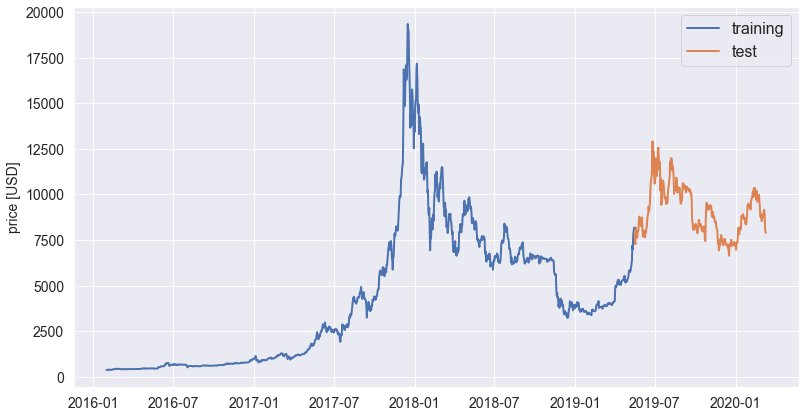

In [53]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [54]:
# Resampling to monthly frequency
btc_month = hist.resample('M').mean()
btc_month

,close,high,low,open,volumefrom,volumeto
time,,,,,,
2016-01-31,369.840000,380.540000,366.880000,377.760000,39019.710000,1.471886e+07
2016-02-29,403.789655,408.631034,396.320690,401.501034,68712.329655,2.781817e+07
2016-03-31,414.957097,419.267742,410.085806,415.620000,53618.589355,2.227969e+07
2016-04-30,433.446667,436.389000,428.483000,432.351000,46366.109000,2.032139e+07
2016-05-31,461.351613,466.723226,453.341290,458.758387,53650.044839,2.544333e+07
2016-06-30,639.645667,656.759333,612.776667,634.942333,118265.938667,7.733940e+07
2016-07-31,660.155161,669.309355,648.346452,661.708387,52430.285161,3.459249e+07
2016-08-31,578.019032,587.523871,568.644516,579.567097,34797.561935,2.018632e+07
2016-09-30,605.738000,614.062667,599.484667,604.596000,24951.627000,1.515226e+07


Dickey–Fuller test: p=0.333794


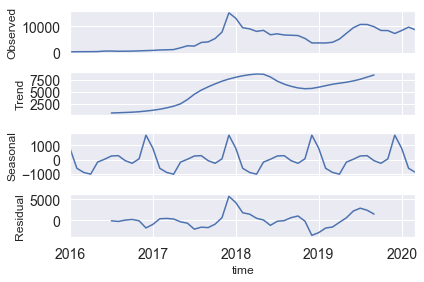

In [55]:
#seasonal_decompose(btc_month.close, freq=12).plot()
seasonal_decompose(btc_month.close, model='additive').plot()
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.close)[1])

In [56]:
# Box-Cox Transformations
btc_month['close_box'], lmbda = stats.boxcox(btc_month.close)
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.close_box)[1])

Dickey–Fuller test: p=0.487448


In [57]:
# Seasonal differentiation (12 months)
btc_month['box_diff_seasonal_12'] = btc_month.close_box - btc_month.close_box.shift(12)
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff_seasonal_12[12:])[1])

Dickey–Fuller test: p=0.396694


In [58]:
# Seasonal differentiation (3 months)
btc_month['box_diff_seasonal_3'] = btc_month.close_box - btc_month.close_box.shift(3)
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff_seasonal_3[3:])[1])

Dickey–Fuller test: p=0.058830


Dickey–Fuller test: p=0.000976


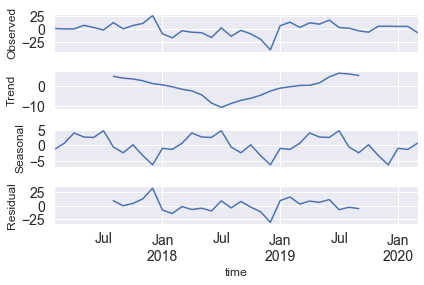

In [59]:
# Regular differentiation
btc_month['box_diff2'] = btc_month.box_diff_seasonal_12 - btc_month.box_diff_seasonal_12.shift(1)

# STL-decomposition
seasonal_decompose(btc_month.box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff2[13:])[1])

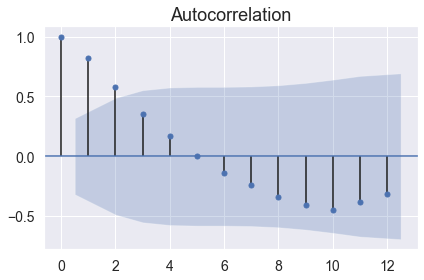

In [60]:
#autocorrelation_plot(btc_month.close)
plot_acf(btc_month.close[13:].values.squeeze(), lags=12)
plt.tight_layout()

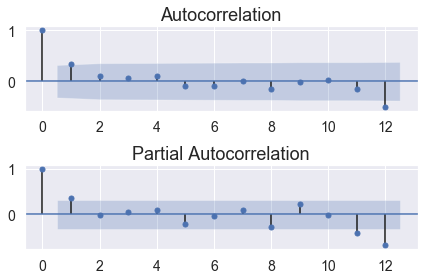

In [61]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
ax = plt.subplot(211)
# Plot the autocorrelation function
#sm.graphics.tsa.plot_acf(btc_month.box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plot_acf(btc_month.box_diff2[13:].values.squeeze(), lags=12, ax=ax)
ax = plt.subplot(212)
#sm.graphics.tsa.plot_pacf(btc_month.box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plot_pacf(btc_month.box_diff2[13:].values.squeeze(), lags=12, ax=ax)
plt.tight_layout()

In [62]:
# Initial approximation of parameters
qs = range(0, 3)
ps = range(0, 3)
d=1
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model = SARIMAX(btc_month.close_box, order=(param[0], d, param[1])).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [63]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

  parameters         aic
3     (1, 0)  330.979103
1     (0, 1)  331.393000
2     (0, 2)  332.875467
6     (2, 0)  332.911471
4     (1, 1)  332.915467


In [64]:
print(best_model.summary())

                           Statespace Model Results                           
Dep. Variable:              close_box   No. Observations:                   51
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -163.490
Date:                Tue, 10 Mar 2020   AIC                            330.979
Time:                        15:13:21   BIC                            334.803
Sample:                    01-31-2016   HQIC                           332.435
                         - 03-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3477      0.069      5.075      0.000       0.213       0.482
sigma2        40.4123      5.252      7.695      0.000      30.118      50.706
Ljung-Box (Q):                       17.68   Jarque-

In [65]:
print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[13:])[1])

Dickey–Fuller test:: p=0.000000


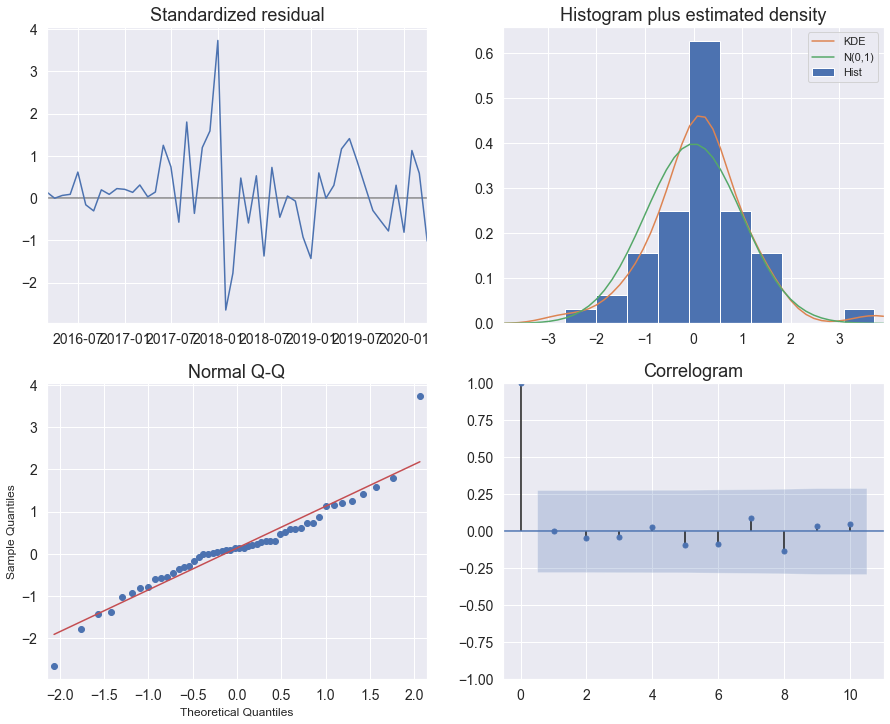

In [66]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [67]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

In [68]:
# Prediction
btc_month_pred = btc_month[['close']]
btc_month_pred

,close
time,
2016-01-31,369.840000
2016-02-29,403.789655
2016-03-31,414.957097
2016-04-30,433.446667
2016-05-31,461.351613
2016-06-30,639.645667
2016-07-31,660.155161
2016-08-31,578.019032
2016-09-30,605.738000


In [69]:
date_list = [datetime(2020, 4, 30), datetime(2020, 5, 31), datetime(2020, 6, 30)]
future = pd.DataFrame(index=date_list, columns= btc_month.columns)
btc_month_pred = pd.concat([btc_month_pred, future])

Text(0, 0.5, 'USD')

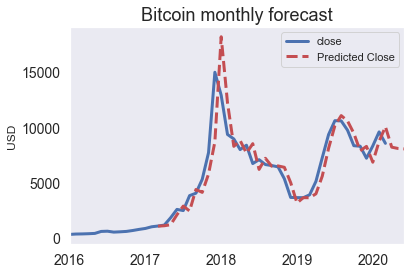

In [70]:
#btc_month_pred['forecast'] = invboxcox(best_model.predict(start=0, end=75), lmbda)
btc_month_pred['forecast'] = invboxcox(best_model.predict(start=datetime(2017, 3, 31), end=datetime(2020, 6, 30)), lmbda)

btc_month_pred.close.plot(linewidth=3)
btc_month_pred.forecast.plot(color='r', ls='--', label='Predicted Close', linewidth=3)
plt.legend()
plt.grid()
plt.title('Bitcoin monthly forecast')
plt.ylabel('USD')

In [100]:
y_forecasted = btc_month_pred.forecast
y_truth = btc_month_pred['2020-02-29':'2020-03-31'].close
y_forecasted_three_months=y_forecasted['2020-02-29':'2020-03-31']
#print(y_forecasted)
print(y_truth)
print(y_forecasted_three_months)
# Compute the root mean square error
rmse = np.sqrt(((y_forecasted - y_truth) ** 2).mean())
print("RMSE:",rmse)

2020-02-29    9641.877931
2020-03-31    8604.054000
Name: close, dtype: float64
2020-02-29     8783.877353
2020-03-31    10107.981110
Name: forecast, dtype: float64
RMSE: 1224.3287434219947


In [71]:
btc_month_predict = btc_month['2020-01-31':'2020-03-31']

# Get a naive forecast
close_history = [x for x in btc_month_predict['close']]
predictions = list()
for i in range(len(btc_month_predict)):
    # predict
    predictions.append(close_history[-1])
    # update observation
    close_history.append(btc_month_predict.iloc[i]['close'])
    
# Calculate RMSE
rmse = sqrt(mean_squared_error(btc_month_predict['close'], predictions))
print('RMSE: %.2f' % rmse)

RMSE: 955.44


In [82]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=CAD&limit=500')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'close'

In [83]:
train, test = train_test_split(hist, test_size=0.2)

In [84]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [85]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [86]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [87]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear', dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model

In [88]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [89]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
396/396 [==============================] - 2s 6ms/step - loss: 0.0117
Epoch 2/20
396/396 [==============================] - 0s 1ms/step - loss: 0.0080
Epoch 3/20
396/396 [==============================] - 0s 967us/step - loss: 0.0058
Epoch 4/20
396/396 [==============================] - 0s 853us/step - loss: 0.0045
Epoch 5/20
396/396 [==============================] - 0s 709us/step - loss: 0.0042
Epoch 6/20
396/396 [==============================] - 0s 646us/step - loss: 0.0037
Epoch 7/20
396/396 [==============================] - 0s 644us/step - loss: 0.0041
Epoch 8/20
396/396 [==============================] - 0s 588us/step - loss: 0.0039
Epoch 9/20
396/396 [==============================] - 0s 586us/step - loss: 0.0034
Epoch 10/20
396/396 [==============================] - 0s 485us/step - loss: 0.0037
Epoch 11/20
396/396 [==============================] - 0s 444us/step - loss: 0.0030
Epoch 12/20
396/396 [==============================] - ETA: 0s - loss: 0.004 - 0s 442us/s

In [90]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.024565773768515684

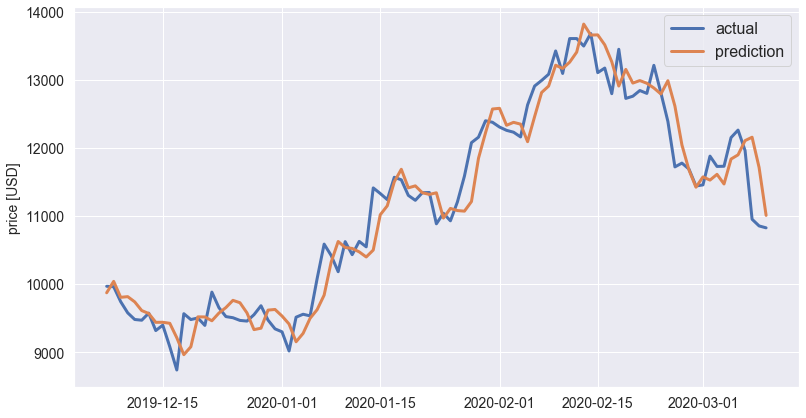

In [91]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

In [92]:
rmse = np.sqrt(((preds - targets) ** 2).mean())
print('Root Mean Squared Error: {}'.format(round(rmse, 2)))

Root Mean Squared Error: 352.97


Root Mean Squared Error value of ARIMA : 955.17

Root Mean Squared Error value of LSTM  : 352.39